In [52]:
#!/usr/bin/python
import os
import sys
import cPickle as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.linear_model import LogisticRegression      
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from tester import dump_classifier_and_data, test_classifier  
import tester
sys.path.append('..\tools')
from feature_format import featureFormat, targetFeatureSplit

There are 146 people in Enron dataset.
There are 21 number of features in Enron dataset.
List of features:
	1.salary
	2.to_messages
	3.deferral_payments
	4.total_payments
	5.loan_advances
	6.bonus
	7.email_address
	8.restricted_stock_deferred
	9.total_stock_value
	10.shared_receipt_with_poi
	11.long_term_incentive
	12.exercised_stock_options
	13.from_messages
	14.other
	15.from_poi_to_this_person
	16.from_this_person_to_poi
	17.poi
	18.deferred_income
	19.expenses
	20.restricted_stock
	21.director_fees
There are 18, POI in Enron dataset.
There are 128 non-POI in Enron dataset.
There are 0 unlabeled POI in Enron dataset.
	HANNON KEVIN P
	COLWELL WESLEY
	RIEKER PAULA H
	KOPPER MICHAEL J
	SHELBY REX
	DELAINEY DAVID W
	LAY KENNETH L
	BOWEN JR RAYMOND M
	BELDEN TIMOTHY N
	FASTOW ANDREW S
	CALGER CHRISTOPHER F
	RICE KENNETH D
	SKILLING JEFFREY K
	YEAGER F SCOTT
	HIRKO JOSEPH
	KOENIG MARK E
	CAUSEY RICHARD A
	GLISAN JR BEN F
There are 35 POI in txt file.
defaultdict(<type 'int'>, {'salary': 5

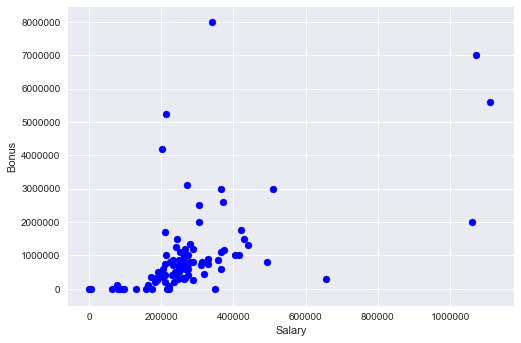

In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances',
                 'bonus', 'restricted_stock_deferred', 'total_stock_value', 'long_term_incentive',
                 'exercised_stock_options', 'other', 'deferred_income', 'expenses','restricted_stock', 'director_fees',
                 'shared_receipt_with_poi', 'from_poi_to_this_person',
                 'from_this_person_to_poi']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### How many people are in Enron dataset?    
print "There are {0} people in Enron dataset.".format(len(data_dict))

### Number of features
features_unique=set()
for feature in data_dict.values():
    for key in feature.keys():
        features_unique.add(key)
print "There are {0} number of features in Enron dataset.".format(len(features_unique))         
print "List of features:"
nr_feature=0
for f in features_unique:
    nr_feature+=1
    print "\t"+str(nr_feature)+'.'+str(f)

### How many POI in Enron dataset?
count_poi=0
count_non_poi=0
unlabeled_poi=0
for key in data_dict:
    global count_poi,count_non_poi
    if data_dict[key]['poi']==True:
        count_poi+=1
    if data_dict[key]['poi']==False:
        count_non_poi+=1

unlabeled_poi=len(data_dict)-count_poi-count_non_poi
print "There are {0}, POI in Enron dataset.".format(count_poi)+'\n',\
      "There are {0} non-POI in Enron dataset.".format(count_non_poi)+'\n',\
      "There are {0} unlabeled POI in Enron dataset.".format(unlabeled_poi)  

for key in data_dict:
    if data_dict[key]['poi']==True:
        print"\t"+str( key)

### How many POI exist in poi_names.txt?
count=0
poi_names=open("../final_project/poi_names.txt").read().split(',')
for name in poi_names:
    if "(y)" in name or "(n)" in name:
        count+=1
print "There are {0} POI in txt file.".format(count)        

### How many NaNs or 0 for each feature?
my_dict= defaultdict(int)

for feature in data_dict.values():
    for key in feature.keys():
        if feature[key]=='NaN' :
            my_dict[key]+=1  
print my_dict            
for k,v in my_dict.iteritems():
    print "Feature {0} has -->{1} missings.".format(k.upper(),v)
    print '\t Percent : {:.2%}'.format( float(v)/len(data_dict) )

### Recode NaNs to zero    
for feature in data_dict.values():
    for key in feature.keys():
        if feature[key]=='NaN':
            feature[key]=0

### How many POIs have missing financial information (total payments)?
count_poi=0
count_nonpoi=0
for key in data_dict:
    if data_dict[key]['poi'] and (data_dict[key]['total_payments']==0):
        count_poi+=1
    if not data_dict[key]['poi'] and (data_dict[key]['total_payments']==0):
        count_nonpoi+=1 
print 'Number of POIs with missing financial information:', count_poi
print 'Number of nonPOIs with missing financial information:', count_nonpoi

### MAX Total payment and which person has it?
max_payments=0
for key in data_dict:
    if int(data_dict[key]['total_payments'])>max_payments:
        max_payments=data_dict[key]['total_payments']
print "The maximum total payments is:", max_payments

for key in data_dict:
    if data_dict[key]['total_payments']==max_payments:
        print "The person with the maximum total payments is:", key

        
### Task 2: Remove outliers

data_dict.pop('TOTAL',0)

### List all names to see if there are other strange values, like Total
i=0
for k in data_dict:
    i+=1
    print '---------------------\n',i,'.',k

### We find "THE TRAVEL AGENCY IN THE PARK" which should also be removed.
data_dict.pop('THE TRAVEL AGENCY IN THE PARK',0)

### Number of names in Enron dataset:
print 'Final number of names in the Enron dataset:',len(data_dict)





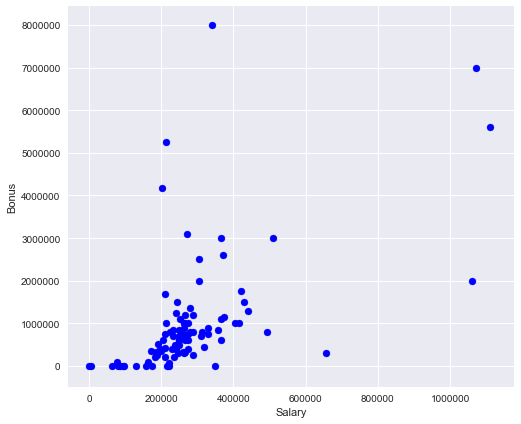

In [31]:
#scatterplot bonus vs salary
features=["salary","bonus"]
data=featureFormat(data_dict,features)
plt.figure(1, figsize=(8, 7))
for i in data:
    salary=i[0]
    bonus=i[1]
    plt.scatter(salary,bonus,color='b')
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.show()

In [4]:
### Check if total payments and total stocks are correct
print 'Wrong total payments for:'
print '-------------------------'
for name in data_dict:
    total_financ=0
    total_financ=data_dict[name]["salary"]+data_dict[name]["deferred_income"]+data_dict[name]["expenses"]+\
                 data_dict[name]["other"]+data_dict[name]["long_term_incentive"]+\
                 data_dict[name]["director_fees"]+data_dict[name]["deferral_payments"]+\
                 data_dict[name]["loan_advances"]+data_dict[name]["bonus"]
    if data_dict[name]["total_payments"]!=total_financ:
        print name,data_dict[name]["total_payments"],total_financ

              
print 'Wrong total stocks for:'
print '-------------------------'
for name in data_dict:   
    total_stock=0  
    total_stock=data_dict[name]["restricted_stock"]+data_dict[name]["exercised_stock_options"]+\
                data_dict[name]["restricted_stock_deferred"]
    if data_dict[name]["total_stock_value"]!=total_stock:

        print name,data_dict[name]["total_stock_value"],total_stock

### Correct total_payments
for name in data_dict:
    if name=='BELFER ROBERT':
        print 'total_payments:',data_dict[name]['total_payments'],
        print 'exercised_stock_options:',data_dict[name]['exercised_stock_options'],
        print 'restricted_stock:',data_dict[name]['restricted_stock'],
        print 'restricted_stock_deferred:',data_dict[name]['restricted_stock_deferred'], 
        print 'total_stock_value:',data_dict[name]['total_stock_value']
        print 'expenses',data_dict[name]['expenses']
        print 'deferral_payments',data_dict[name]['deferral_payments']

for name in data_dict:
    if data_dict[name]['restricted_stock_deferred']>0 and data_dict[name]['restricted_stock_deferred']!=0:
        print data_dict[name]['restricted_stock_deferred'],name

#correct the features values for this BELFER ROBERT and BHATNAGAR SANJAY        
for name in data_dict:
    if name=='BELFER ROBERT':
        data_dict[name]['salary']=0
        data_dict[name]['deferral_payments']=0
        data_dict[name]['total_payments']=3285
        data_dict[name]['loan_advances']=0
        data_dict[name]['bonus']=0
        data_dict[name]['restricted_stock_deferred']=-44093
        data_dict[name]['total_stock_value']=0
        data_dict[name]['long_term_incentive']=0
        data_dict[name]['exercised_stock_options']=0
        data_dict[name]['other']=0
        data_dict[name]['deferred_income']=-102500
        data_dict[name]['expenses']=3285
        data_dict[name]['restricted_stock']=44093
        data_dict[name]['director_fees']=102500

for name in data_dict:
    if name=='BHATNAGAR SANJAY':
        data_dict[name]['salary']=0
        data_dict[name]['deferral_payments']=0
        data_dict[name]['total_payments']=137864
        data_dict[name]['loan_advances']=0
        data_dict[name]['bonus']=0
        data_dict[name]['restricted_stock_deferred']=-2604490
        data_dict[name]['total_stock_value']=15456290
        data_dict[name]['long_term_incentive']=0
        data_dict[name]['exercised_stock_options']=15456290
        data_dict[name]['other']=0
        data_dict[name]['deferred_income']=0
        data_dict[name]['expenses']=137864 
        data_dict[name]['restricted_stock']=2604490
        data_dict[name]['director_fees']=0       

        

Wrong total payments for:
-------------------------
BELFER ROBERT 102500 -99215
BHATNAGAR SANJAY 15456290 275728
Wrong total stocks for:
-------------------------
BELFER ROBERT -44093 47378
BHATNAGAR SANJAY 0 15456290
total_payments: 102500 exercised_stock_options: 3285 restricted_stock: 0 restricted_stock_deferred: 44093 total_stock_value: -44093
expenses 0
deferral_payments -102500
44093 BELFER ROBERT
15456290 BHATNAGAR SANJAY


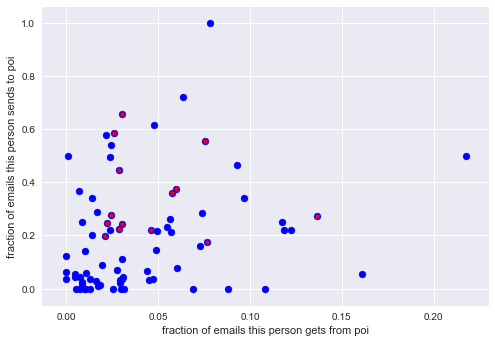

In [5]:
### Task 3: Create new feature(s)
def computeFraction (poi_messages,all_messages):
    '''calculate the fraction of messages from total messages. If both features are 0, return 0'''
    fraction=0.
    if all_messages!=0 and poi_messages!=0:
        fraction=poi_messages/float(all_messages)
    elif all_messages==0 and poi_messages==0:
        fraction=.0
    return fraction

#create dictionary dict_fractions which stores the flag for poi, and the calculated features 
#     fraction_from_poi=from_poi_to_this_person/to_messages and
#     fraction_to_poi=from_this_person_to_poi/from_messages 
#using the function computeFraction

dict_fractions={}
for name in data_dict:
    data_point=data_dict[name]
    from_poi_to_this_person=data_point['from_poi_to_this_person']
    from_this_person_to_poi=data_point['from_this_person_to_poi']
    to_messages=data_point['to_messages']
    from_messages=data_point['from_messages']
    fraction_from_poi=computeFraction(from_poi_to_this_person,to_messages)
    fraction_to_poi=computeFraction(from_this_person_to_poi,from_messages) 
    poi=data_point['poi']
    dict_fractions[name]={"poi":poi,"from_poi_to_this_person":fraction_from_poi,
                          "from_this_person_to_poi":fraction_to_poi}
    

#Visualize the new feature
features_list1=["poi","from_poi_to_this_person","from_this_person_to_poi"]  
data = featureFormat(dict_fractions, features_list1, sort_keys = True)

for point in data:
    from_poi = point[1]
    to_poi = point[2]
    plt.scatter(from_poi, to_poi,color='b')
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r", marker="*")
plt.xlabel("fraction of emails this person gets from poi")
plt.ylabel("fraction of emails this person sends to poi")
plt.show()


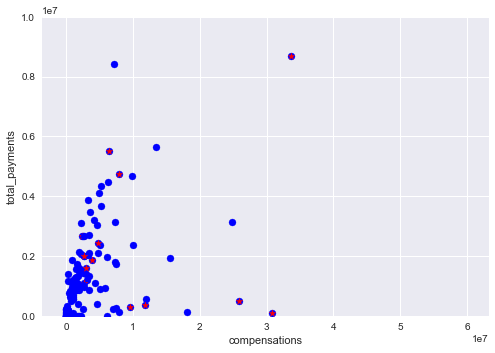

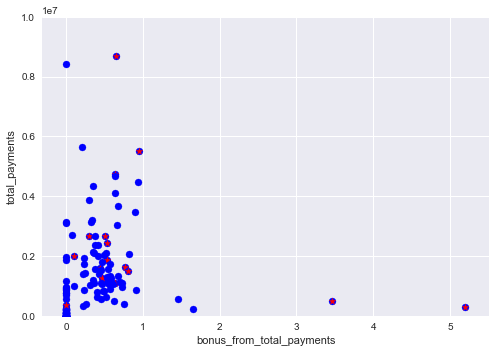

In [6]:
#other new feature
def computeSum(f1,f2,f3,f4):
    '''calculate the sum of features'''
    total= f1+f2+f3+f4
    return total

def compute_share(f1,total):
    '''calculate the fraction of feature from total. If total is 0, return 0'''
    if total==0:
        share=0
    else:
        share=float(f1)/total
    return share

#create dictionary dict_new_features which stores the flag for poi, and the calculated features 
dict_new_features={}
for name in data_dict:
    data_point=data_dict[name]
    exercised_stock_options=data_point['exercised_stock_options']
    restricted_stock=data_point['restricted_stock']
    total_payments=data_point['total_payments']
    salary=data_point['salary']
    bonus=data_point['bonus']
    long_term_incentive=data_point['long_term_incentive']
    poi=data_point['poi']
    compensations=computeSum(bonus,long_term_incentive,exercised_stock_options,restricted_stock)
    bonus_from_total_payments=compute_share(bonus,total_payments)
   
    dict_new_features[name]={"poi":poi,"compensations":compensations,"bonus_from_total_payments":bonus_from_total_payments,
                            "total_payments":total_payments}

    
#Visualize the new feature
features_list2=["poi","compensations","bonus_from_total_payments","total_payments"]  
data = featureFormat(dict_new_features, features_list2, sort_keys = True)

for point in data:
    compensations = point[1]
    total_payments = point[3]
    plt.scatter(compensations, total_payments,color='b')
    if point[0] == 1:
        plt.scatter(compensations, total_payments, color="r", marker="*")
plt.xlabel("compensations")
plt.ylabel("total_payments")
plt.ylim(0,10000000)
plt.show()


for point in data:
    bonus_from_total_payments = point[2]
    total_payments = point[3]
    
    plt.scatter(bonus_from_total_payments, total_payments,color='b')
    if point[0] == 1:
        plt.scatter(bonus_from_total_payments, total_payments, color="r", marker="*")
plt.xlabel("bonus_from_total_payments")
plt.ylabel("total_payments")
plt.ylim(0,10000000)
plt.show()



In [7]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

###Add the new features to the dataset
for name in my_dataset:
    data_point=data_dict[name]
    #add compensations
    exercised_stock_options=data_point['exercised_stock_options']
    restricted_stock=data_point['restricted_stock']
    salary=data_point['salary']
    bonus=data_point['bonus']
    long_term_incentive=data_point['long_term_incentive']
    data_point['compensations']= computeSum(bonus,long_term_incentive,exercised_stock_options,restricted_stock)
    #add bonus_from_total_payments
    data_point['bonus_from_total_payments']= compute_share(bonus,total_payments)
    #add email fractions
    from_poi_to_this_person=data_point['from_poi_to_this_person']
    from_this_person_to_poi=data_point['from_this_person_to_poi']
    to_messages=data_point['to_messages']
    from_messages=data_point['from_messages']
    data_point['fraction_from_poi']=computeFraction(from_poi_to_this_person,to_messages)
    data_point['fraction_to_poi']=computeFraction(from_this_person_to_poi,from_messages) 


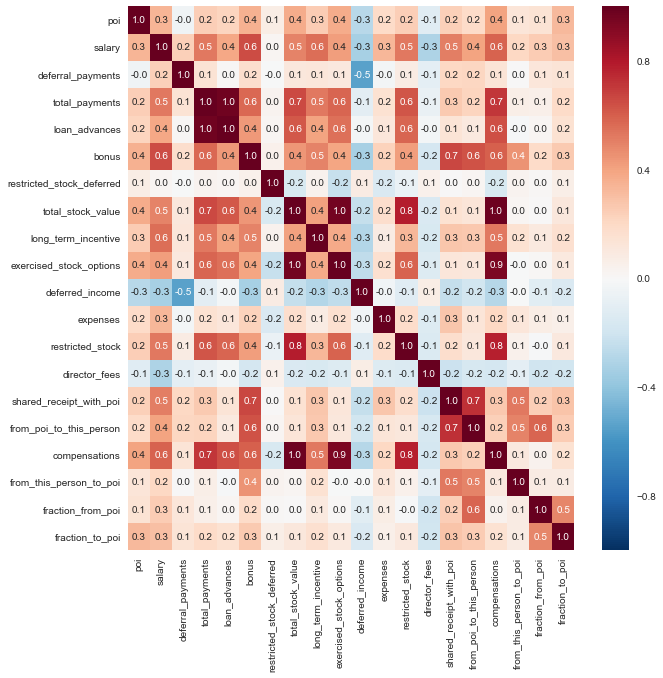

In [48]:
#feature list with the new features
features_list = ['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances',
                 'bonus', 'restricted_stock_deferred', 'total_stock_value', 'long_term_incentive',
                 'exercised_stock_options', 'deferred_income', 'expenses','restricted_stock', 'director_fees',
                 'shared_receipt_with_poi', 'from_poi_to_this_person','compensations',
                 'from_this_person_to_poi','fraction_from_poi','fraction_to_poi']

my_feature_list = features_list

### Extract features and labels (POI feature) from dataset for local testing
data = featureFormat(my_dataset, my_feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


df = pd.DataFrame(data, columns=my_feature_list)
#Correlation Matrix
import seaborn as sns
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))  
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt=".1f")
  

In [33]:
#splitting data into training and test
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)


In [34]:
def classification_model(model):
    '''model fit, predict and confusion matrix'''
    clf=model()
    clf=clf.fit(features_train,labels_train)
    pred=clf.predict(features_test)
    acc=accuracy_score(pred,labels_test)
    report=metrics.classification_report(pred,labels_test)
    # plot_confusion_matrix(clf)    
    plot_confusion_matrix(pred,labels_test)    
    plt.show()
    print 'Accuracy:',accuracy_score(pred,labels_test)
    print 'Report metrics:\n',metrics.classification_report(pred,labels_test)

def plot_confusion_matrix(pred,labels_test):
    '''confusion matrix plot'''
    print 'Confusion matrix'
    mat=confusion_matrix(pred,labels_test)
    sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
    plt.xlabel('actual')
    plt.ylabel('predicted')    

-------------------------------Gaussian Naive Bayes-------------------------------
Confusion matrix


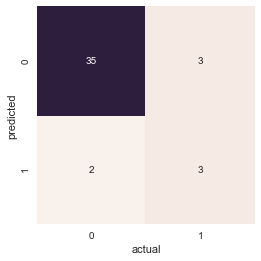

Accuracy: 0.883720930233
Report metrics:
             precision    recall  f1-score   support

        0.0       0.92      0.95      0.93        37
        1.0       0.60      0.50      0.55         6

avg / total       0.88      0.88      0.88        43

None
--------------------------Decision Tree------------------------------------------
Confusion matrix


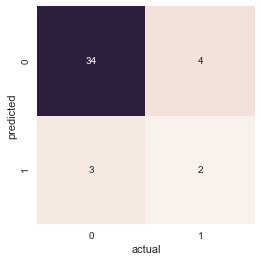

Accuracy: 0.837209302326
Report metrics:
             precision    recall  f1-score   support

        0.0       0.89      0.92      0.91        37
        1.0       0.40      0.33      0.36         6

avg / total       0.83      0.84      0.83        43

None
------------------------------------KNN------------------------------------------
Confusion matrix


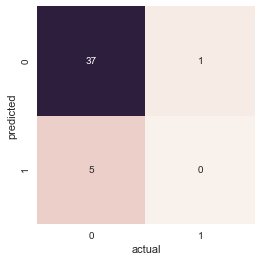

Accuracy: 0.860465116279
Report metrics:
             precision    recall  f1-score   support

        0.0       0.97      0.88      0.93        42
        1.0       0.00      0.00      0.00         1

avg / total       0.95      0.86      0.90        43

None
---------------------Logistic Regression-----------------------------------------
Confusion matrix


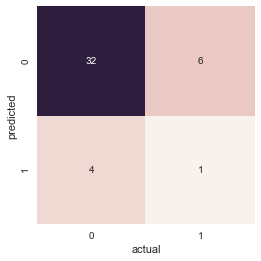

Accuracy: 0.767441860465
Report metrics:
             precision    recall  f1-score   support

        0.0       0.84      0.89      0.86        36
        1.0       0.20      0.14      0.17         7

avg / total       0.74      0.77      0.75        43

None


In [49]:
# Provided to give you a starting point. Try a variety of classifiers.
#from sklearn.naive_bayes import GaussianNB
#clf = GaussianNB()
print '-------------------------------Gaussian Naive Bayes-------------------------------'
clf_GaussianNB=classification_model(GaussianNB)
print clf_GaussianNB

print '--------------------------Decision Tree------------------------------------------'
clf_DecisionTree=classification_model(DecisionTreeClassifier)
print clf_DecisionTree

print '------------------------------------KNN------------------------------------------'
clf_KNN=classification_model(KNeighborsClassifier)
print clf_KNN

print '---------------------Logistic Regression-----------------------------------------'
clf_LR=classification_model(LogisticRegression)
print clf_LR

In [36]:
print '--------------------------Gaussian NB--------------------------------------------'
tester.test_classifier(GaussianNB(),my_dataset,my_feature_list)

print '--------------------------Decision Tree------------------------------------------'
tester.test_classifier(DecisionTreeClassifier(),my_dataset,my_feature_list)

print '------------------------------------KNN------------------------------------------'
tester.test_classifier(KNeighborsClassifier(),my_dataset,my_feature_list)

print '-------------------------LogisticRegression--------------------------------------'
tester.test_classifier(LogisticRegression(),my_dataset,my_feature_list)

--------------------------Gaussian NB--------------------------------------------
GaussianNB(priors=None)
	Accuracy: 0.77893	Precision: 0.28226	Recall: 0.42650	F1: 0.33971	F2: 0.38695
	Total predictions: 15000	True positives:  853	False positives: 2169	False negatives: 1147	True negatives: 10831

--------------------------Decision Tree------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.80593	Precision: 0.26890	Recall: 0.26500	F1: 0.26694	F2: 0.26577
	Total predictions: 15000	True positives:  530	False positives: 1441	False negatives: 1470	True negatives: 11559

------------------------------------KNN---------------------------------------

In [ ]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
#from sklearn.cross_validation import train_test_split
#features_train, features_test, labels_train, labels_test = \
#    train_test_split(features, labels, test_size=0.3, random_state=42)

In [37]:
#----------------------------GaussianNB tunning--------------------------------------
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)

combined_features = FeatureUnion([("pca", PCA()), ("kbest", SelectKBest())])

pipe = Pipeline([
                 ('select_features',combined_features),
                 ('classifier',GaussianNB())
               ])

param_grid = ([{
                'select_features__pca__n_components':list(range(2,8,1)),
                'select_features__kbest__k':list(range( 2,8,1)),
             }])

clf_gs = GridSearchCV(pipe,param_grid,scoring='f1',cv=sss)
clf_f=clf_gs.fit(features, labels)


clf=clf_f.best_estimator_    
#predictions= clf_f.best_estimator_.predict(features_test)
best_parameters = clf_gs.best_estimator_.get_params()

In [38]:
test_classifier(clf, my_dataset, my_feature_list)

Pipeline(memory=None,
     steps=[('select_features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('kbest', SelectKBest(k=2, score_func=<function f_classif at 0x000000000C240C88>))],
       transformer_weights=None)), ('classifier', GaussianNB(priors=None))])
	Accuracy: 0.84987	Precision: 0.42410	Recall: 0.35200	F1: 0.38470	F2: 0.36439
	Total predictions: 15000	True positives:  704	False positives:  956	False negatives: 1296	True negatives: 12044



In [57]:
#-----------------------------Decision Tree tunning-----------------------------

combined_features = FeatureUnion([("pca", PCA()), ("kbest", SelectKBest())])

pipe = Pipeline([
                 ('select_features',combined_features),
                 ('classifier',DecisionTreeClassifier())
               ])

param_grid = ([{
                'select_features__pca__n_components':list(range(2,8,1)),
                'select_features__kbest__k':list(range(2,14,1)),
                'classifier__class_weight':['balanced'],
                'classifier__criterion':['gini', 'entropy'],
                'classifier__max_depth': [1,2,4,8,16,32],
                'classifier__random_state':[42],
                'classifier__min_samples_split':[2,4,8,16,32],
                'classifier__min_samples_leaf': [2,4,8,16,32]
             }])

clf_gs = GridSearchCV(pipe,param_grid,scoring='f1',cv=sss)
clf_f=clf_gs.fit(features, labels)
clf=clf_f.best_estimator_    

best_parameters = clf_gs.best_estimator_.get_params()

In [58]:
print '----------------Best parameters----------------'
for param_name in (param_grid):
    for key in param_name:
        print '\t%s: %r' % (key, best_parameters[key]) 


----------------Best parameters----------------
	select_features__kbest__k: 9
	classifier__random_state: 42
	classifier__min_samples_split: 16
	select_features__pca__n_components: 2
	classifier__class_weight: 'balanced'
	classifier__min_samples_leaf: 2
	classifier__max_depth: 8
	classifier__criterion: 'entropy'


In [59]:
tester.test_classifier(clf, my_dataset, my_feature_list)

Pipeline(memory=None,
     steps=[('select_features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('kbest', SelectKBest(k=9, score_func=<function f_classif at 0x000000000C240C88>))],
       transf...        min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])
	Accuracy: 0.79227	Precision: 0.33788	Recall: 0.58150	F1: 0.42742	F2: 0.50822
	Total predictions: 15000	True positives: 1163	False positives: 2279	False negatives:  837	True negatives: 10721



In [71]:
tester.dump_classifier_and_data(clf, my_dataset, my_feature_list)

In [60]:
print '\n----------------Feature ranking----------------\n'

f_importance=np.array(clf.named_steps['select_features'].get_params()['kbest'].scores_)
print 'Best features selected:', (np.array(clf.named_steps['select_features'].get_params()['kbest'].get_support(indices=True)))
print 'Features importance:'
indices = np.argsort(f_importance)[::-1]
for f in range(np.array(features_train).shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f] , f_importance[indices[f]]))


----------------Feature ranking----------------

Best features selected: [ 0  4  6  8 10 11 13 15 18]
Features importance:
1. feature 15 (18.430407)
2. feature 6 (14.689864)
3. feature 8 (13.714161)
4. feature 0 (11.196268)
5. feature 4 (11.129479)
6. feature 18 (8.243016)
7. feature 11 (6.572702)
8. feature 10 (5.898734)
9. feature 13 (5.495321)
10. feature 9 (5.279110)
11. feature 14 (3.590680)
12. feature 2 (2.771634)
13. feature 7 (2.611274)
14. feature 17 (2.349338)
15. feature 16 (2.143841)
16. feature 12 (1.961608)
17. feature 5 (0.793834)
18. feature 1 (0.263968)
19. feature 3 (0.197149)



----------Plot the feature importances---------


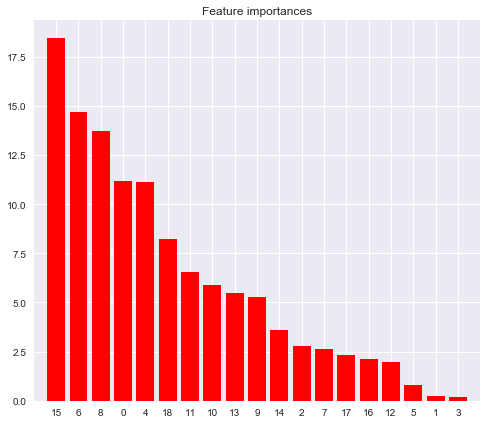

In [69]:
print '\n----------Plot the feature importances---------'
plt.figure(1, figsize=(8, 7))
plt.title("Feature importances")
plt.bar(range(np.array(features_train).shape[1]), f_importance[indices],
              color="r",  align="center")
plt.xticks(range(np.array(features_train).shape[1]), indices)
plt.xlim([-1, np.array(features_train).shape[1]])
plt.savefig('featureimportance.png')
plt.show()


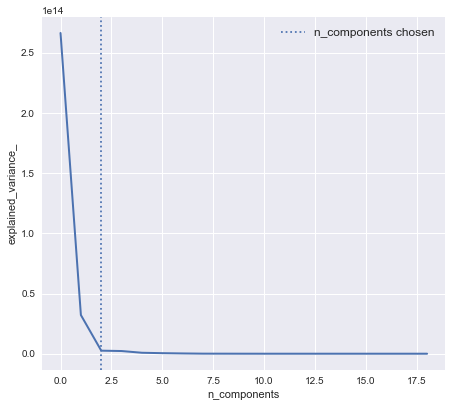

In [70]:
# Plot the PCA spectrum
from sklearn import  decomposition

k=len(np.array(clf.named_steps['select_features'].get_params()['kbest'].get_support(indices=True)))


pca = decomposition.PCA()
pca.fit(features_train)
plt.figure(1, figsize=(8, 7))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
#plot the best_estimator pca
plt.axvline(clf_gs.best_estimator_.named_steps['select_features'].get_params()['pca'].n_components,
                linestyle=':', label='n_components chosen')

plt.legend(prop=dict(size=12))
plt.savefig('PCA_variance.png')
plt.show()  


In [55]:
#-----------------------------KNN tunning-----------------------------------         

combined_features = FeatureUnion([("pca", PCA()), ("kbest", SelectKBest())])

pipe = Pipeline([('scaler',StandardScaler()),
                 ('select_features',combined_features),
                 ('classifier',KNeighborsClassifier())
                ])

param_grid = ([{
               # 'scaler__with_std': [True, False],
                'select_features__pca__n_components':list(range(2,8,1)),
                'select_features__kbest__k':list(range(2,14,1)),
                'classifier__n_neighbors':  range(2,20), 
                'classifier__weights': ['uniform', 'distance'],
                'classifier__algorithm':['auto','ball_tree','kd_tree']
             }])

clf_gs = GridSearchCV(pipe,param_grid,scoring='f1',cv=sss)
clf_f=clf_gs.fit(features, labels)
best_parameters = clf_gs.best_estimator_.get_params()

clf=clf_f.best_estimator_    

In [43]:
print '----------------Best parameters----------------'
for param_name in (param_grid):
    for key in param_name:
        print '\t%s: %r' % (key, best_parameters[key]) 


----------------Best parameters----------------
	select_features__pca__n_components: 2
	select_features__kbest__k: 3
	classifier__algorithm: 'auto'
	classifier__n_neighbors: 2
	classifier__weights: 'distance'


In [56]:
tester.test_classifier(clf, my_dataset, my_feature_list)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select_features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('kbest', SelectKBest(k=3, s...wski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='distance'))])
	Accuracy: 0.83600	Precision: 0.38569	Recall: 0.38800	F1: 0.38684	F2: 0.38753
	Total predictions: 15000	True positives:  776	False positives: 1236	False negatives: 1224	True negatives: 11764



In [50]:
#-----------------------------LogisticRegression tunning-----------------------------------  
         
combined_features = FeatureUnion([("pca", PCA()), ("kbest", SelectKBest())])

pipe = Pipeline([
                 ('select_features',combined_features),
                 ('classifier',LogisticRegression())
                ])

param_grid = ([{
                
                'select_features__pca__n_components':list(range(2,8,1)),
                'select_features__kbest__k':list(range(2,14,1)),
                'classifier__tol':  [0.01,0.02,0.03,0.04,0.05,0.001,0.005,0.0001], 
                'classifier__C': [0.001,0.002,0.003,0.004,0.005,0.01,0.05, 0.5, 1, 10],
                'classifier__class_weight':['balanced'],
                'classifier__random_state':[42]

             }])

clf_gs = GridSearchCV(pipe,param_grid,scoring='f1',cv=sss)
clf_f=clf_gs.fit(features, labels)


clf=clf_f.best_estimator_    
best_parameters = clf_gs.best_estimator_.get_params()

In [ ]:
print '----------------Best parameters----------------'
for param_name in (param_grid):
    for key in param_name:
        print '\t%s: %r' % (key, best_parameters[key]) 


In [51]:
tester.test_classifier(clf, my_dataset, my_feature_list)

Pipeline(memory=None,
     steps=[('select_features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('kbest', SelectKBest(k=2, score_func=<function f_classif at 0x000000000C240C88>))],
       transf...enalty='l2', random_state=42,
          solver='liblinear', tol=0.01, verbose=0, warm_start=False))])
	Accuracy: 0.77140	Precision: 0.30398	Recall: 0.55400	F1: 0.39256	F2: 0.47574
	Total predictions: 15000	True positives: 1108	False positives: 2537	False negatives:  892	True negatives: 10463

